# Avila

This data in this dataset are part of a paleographic analysis of 8000 pages from the 'Avila Bible'. Manuscript pages are written by 12 copyists, which is the target class.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)
sns.set_style('white')

%matplotlib inline

In [2]:
names = []
for i in range(10):
    names.append('F' + str(i+1))
    
names.append('Class')

In [3]:
avila_X = pd.read_csv('../data/bronze/avila/avila-tr.txt', header=0, names=names)
avila_y = pd.read_csv('../data/bronze/avila/avila-ts.txt', header=0, names=names)

In [4]:
TARGET = 'Class'
COLUMNS = [col for col in avila_X.columns if col != TARGET]

In [5]:
avila_X.head()

F1        F2        F3        F4        F5        F6        F7  \
0  0.130292  0.870736 -3.210528  0.062493  0.261718  1.436060  1.465940   
1 -0.116585  0.069915  0.068476 -0.783147  0.261718  0.439463 -0.081827   
2  0.031541  0.297600 -3.210528 -0.583590 -0.721442 -0.307984  0.710932   
3  0.229043  0.807926 -0.052442  0.082634  0.261718  0.148790  0.635431   
4  0.117948 -0.220579 -3.210528 -1.623238  0.261718 -0.349509  0.257927   

         F8        F9       F10 Class  
0  0.636203  0.282354  0.515587     A  
1 -0.888236 -0.123005  0.582939     A  
2  1.051693  0.594169 -0.533994     A  
3  0.051062  0.032902 -0.086652     F  
4 -0.385979 -0.247731 -0.331310     A

In [6]:
avila_y.head()

F1        F2        F3        F4        F5        F6        F7  \
0  0.204355 -0.354049  0.320980  0.410166 -0.989576 -2.218127  0.220177   
1  0.759828 -1.304042 -0.023991 -0.973663 -0.006417 -0.349509 -0.421580   
2 -0.005490  0.360409  0.281860 -0.213479 -1.168333 -1.013906 -0.346080   
3  0.080916  0.101320  0.104040  0.140490  0.261718  0.480988  0.710932   
4  0.068573 -0.181323 -3.210528 -0.294311 -1.168333  0.356414 -0.006326   

         F8        F9       F10 Class  
0  0.181844  2.090879 -2.009758     A  
1 -0.450127  0.469443  0.060952     I  
2  1.176165  0.968347 -0.627999     E  
3 -0.253430 -0.497183  0.155681     A  
4 -0.219550  0.126447  0.448186     F

In [7]:
avila = pd.concat([avila_X, avila_y], ignore_index=True)

In [8]:
avila.describe()

F1            F2            F3            F4            F5  \
count  20865.000000  20865.000000  20865.000000  20865.000000  20865.000000   
mean       0.000155      0.018496      0.002303      0.000034      0.000228   
std        0.999760      2.853253      1.058250      1.000004      0.999461   
min       -3.498799     -2.426761     -3.210528     -5.440122     -4.922215   
25%       -0.128929     -0.259834      0.064919     -0.527256      0.172340   
50%        0.056229     -0.055704      0.217845      0.089437      0.261718   
75%        0.204355      0.203385      0.352988      0.643738      0.261718   
max       11.819916    386.000000     50.000000      3.987152      1.066121   

                 F6            F7            F8            F9           F10  
count  20865.000000  20865.000000  20865.000000  20865.000000  20865.000000  
mean       0.002472      0.003951     -0.000008      0.002102      0.000010  
std        1.065199      1.153377      1.000030      1.045411      1.000029  
min       -7.450257    -11.935457     -4.247781     -5.486218     -6.719324  
25%       -0.598658     -0.044076     -0.543924     -0.372457     -0.515248  
50%       -0.058835      0.220177      0.108279      0.064084     -0.025954  
75%        0.564038      0.446679      0.648765      0.500624      0.528401  
max       53.000000     83.000000     13.173081     44.000000     11.911338

## Data Preprocessing

The dataset has been normalised using Z normalisation as per the dataset description: **x' = (x - μ) / σ**.

There are some strange outliers in some columns and there are no **null** nor **n/a** values.

In order to maximise data utilisation, the test and training datasets were combined, where the datasets will be split later with different proportions.

There are some rows and columns within the dataset which should not be removed, as it will result in the removal of particular copyists from the target class.

### Outliers

In [9]:
# Dropping an extreme outlier in F2
avila = avila[~(avila['F2'] > 100)]

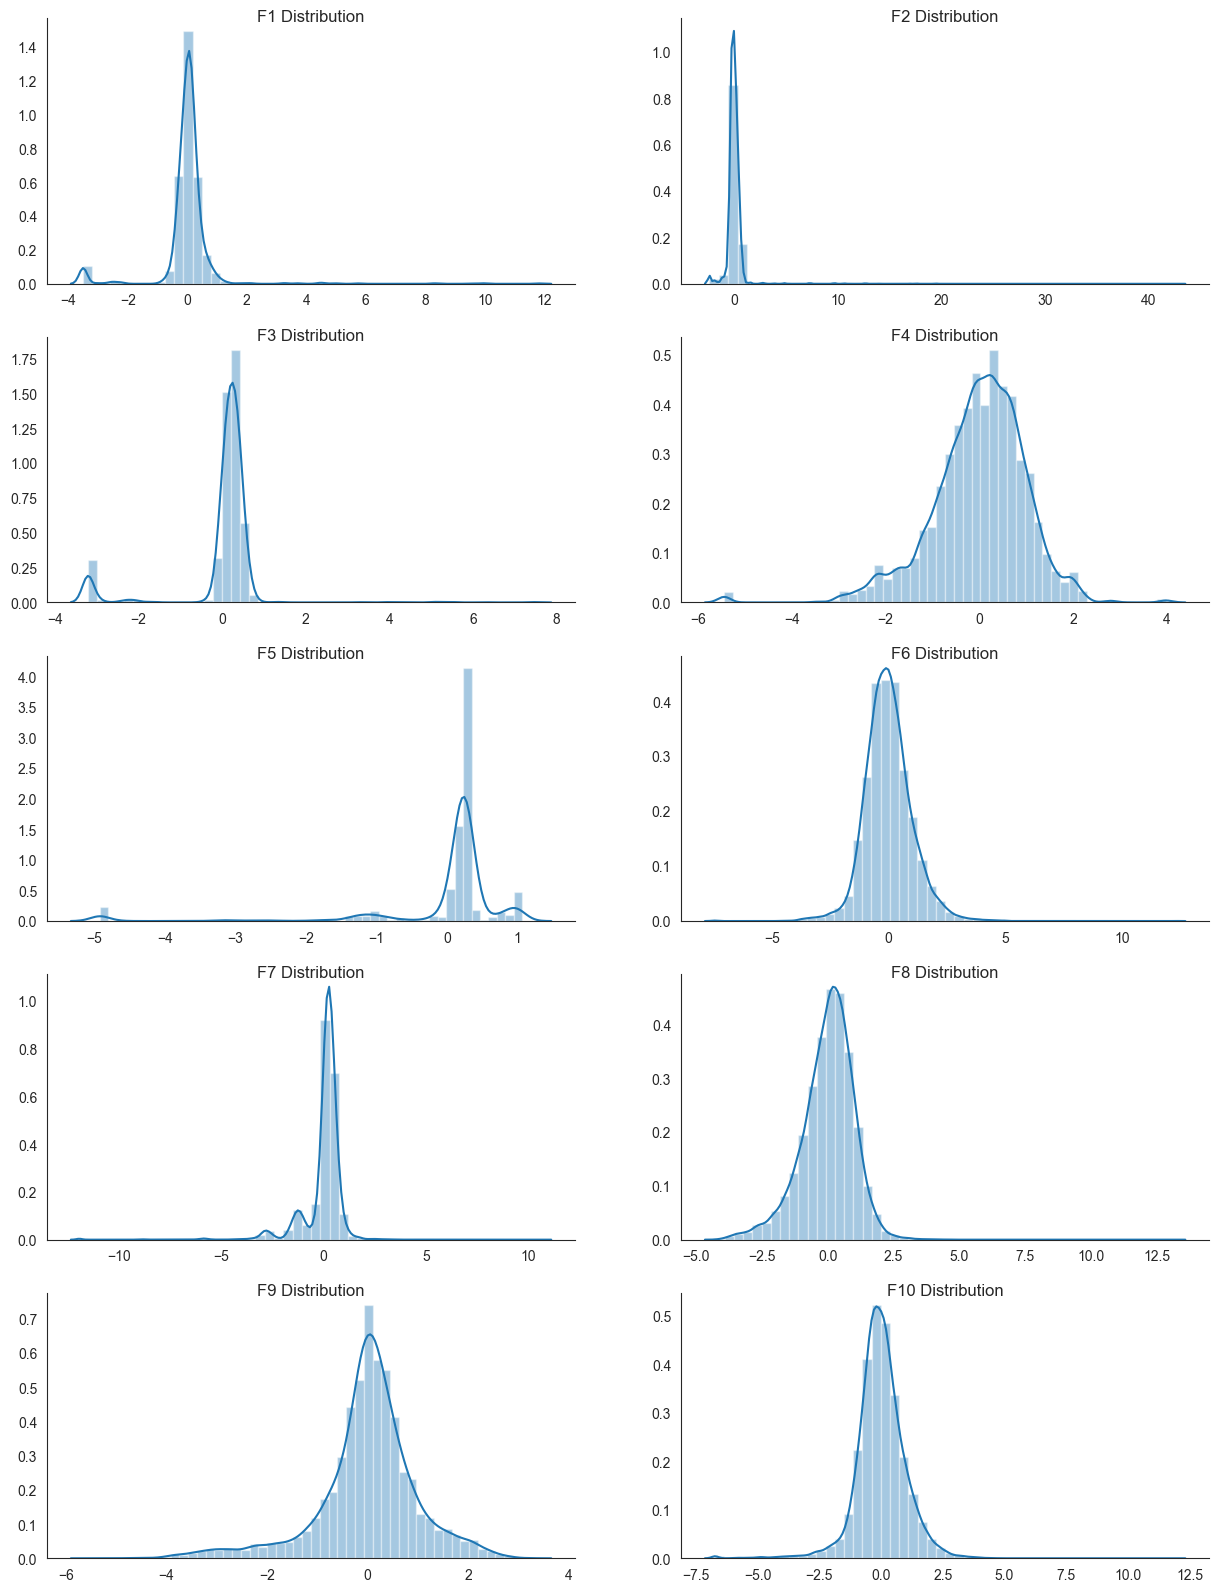

In [10]:
plt.subplots(5, 2, figsize=(15,20))

plotnumber = 1

for col in COLUMNS:
    if plotnumber < len(COLUMNS) + 1:
        plt.subplot(5, 2, plotnumber)
        
        sns.distplot(avila[col])
        sns.despine()
        
        plt.title('{feature} Distribution'.format(feature=col), pad=-2)
        plt.xlabel(None)
        plt.ylabel(None)
        
    plotnumber += 1
    
plt.show()

Some of the data doesn't seem to follow a standardised normal distribution, with a large number of data points across different columns appearing more than 5 standard deviations away from the mean. 

The chosen solution is that all data points that are greater than 5 standard deviations to the population mean 0 (mu) to minimise outliers affecting the result of predictions. 

Another option could be to clip the values to a certain amount.

In [11]:
for i in avila.select_dtypes(exclude ='object'):
    avila[i][avila[i] > 5] = 0
    avila[i][avila[i] < -5] = 0

### Correlation

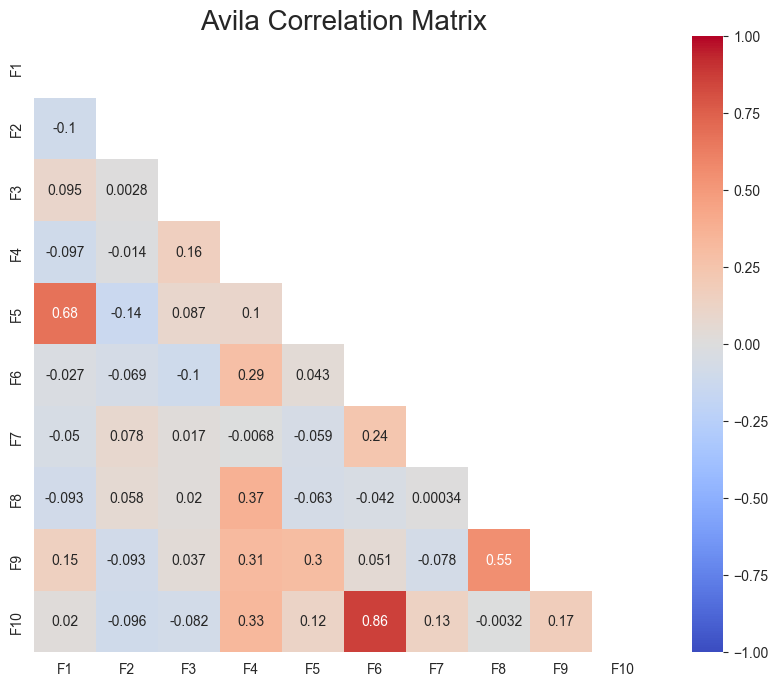

In [12]:
plt.figure(figsize = (10, 8))

corr = avila[COLUMNS].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=mask, cmap='coolwarm')

plt.title('Avila Correlation Matrix', pad=5, fontdict={'fontsize':20} )

plt.show()

Feature 6 and 10 seem to have a high correlation, and after some investigation it seems that feature 10 is derived from feature 6 and another feature as a ratio. 

As this doesn't seem to add much value to the dataset, it was decided that this feature was to be removed.

In [13]:
avila.drop(columns='F10', inplace=True)
avila.describe()

F1            F2            F3            F4            F5  \
count  20864.000000  20864.000000  20864.000000  20864.000000  20864.000000   
mean      -0.038448     -0.052945     -0.021900      0.020885      0.000228   
std        0.795311      0.504414      0.931493      0.941348      0.999485   
min       -3.498799     -2.426761     -3.210528     -3.441837     -4.922215   
25%       -0.128929     -0.259834      0.061363     -0.523467      0.172340   
50%        0.043885     -0.055704      0.214288      0.089437      0.261718   
75%        0.204355      0.203385      0.352988      0.643738      0.261718   
max        4.969080      4.835583      4.329047      3.987152      1.066121   

                 F6            F7            F8            F9  
count  20864.000000  20864.000000  20864.000000  20864.000000  
mean       0.000355      0.040209     -0.000653      0.000758  
std        0.984832      0.787730      0.995884      0.998033  
min       -4.668092     -4.989381     -4.247781     -4.737863  
25%       -0.598658     -0.044076     -0.543943     -0.372457  
50%       -0.058835      0.220177      0.108240      0.064084  
75%        0.564038      0.446679      0.648488      0.500624  
max        4.965672      4.901228      4.580832      3.244594

In [14]:
NEW_COLUMNS = [col for col in avila.columns if col != TARGET]

In [15]:
avila[TARGET].value_counts()

Class
A    8570
F    3923
E    2190
I    1663
X    1044
H    1039
G     893
D     705
Y     533
C     206
W      88
B      10
Name: count, dtype: int64

## Exploratory Data Analysis

Before we perform Exploratory Data Analysis, we need to split the training and test data, as we shouldn't explore the test data.

In [16]:
X = avila[NEW_COLUMNS]
y = avila[TARGET]

print(X.shape)
print(y.shape)

(20864, 9)
(20864,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

### Target Feature

There are some under-represented values in the target class (W and B are of particular concern). Dealing with these values is outside the scope of this project.

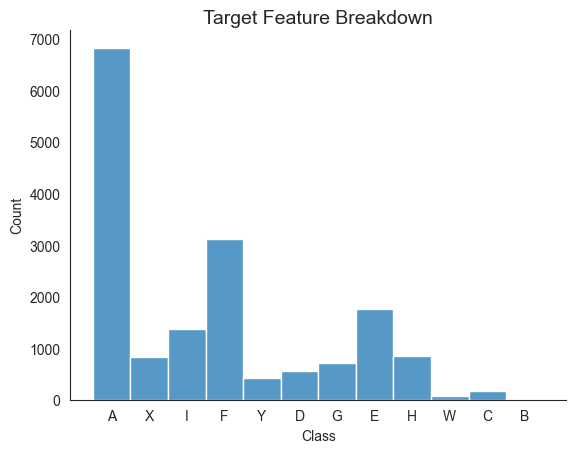

In [18]:
sns.histplot(y_train)
sns.despine()

plt.title('Target Feature Breakdown', pad=5, fontdict={'fontsize':14})

plt.show()

In [19]:
y_train.value_counts()

Class
A    6833
F    3115
E    1768
I    1367
H     841
X     836
G     709
D     563
Y     417
C     163
W      71
B       8
Name: count, dtype: int64

### Feature Distributions

We can see now that most features follow a standard normal distribution, appropriate for data modelling.

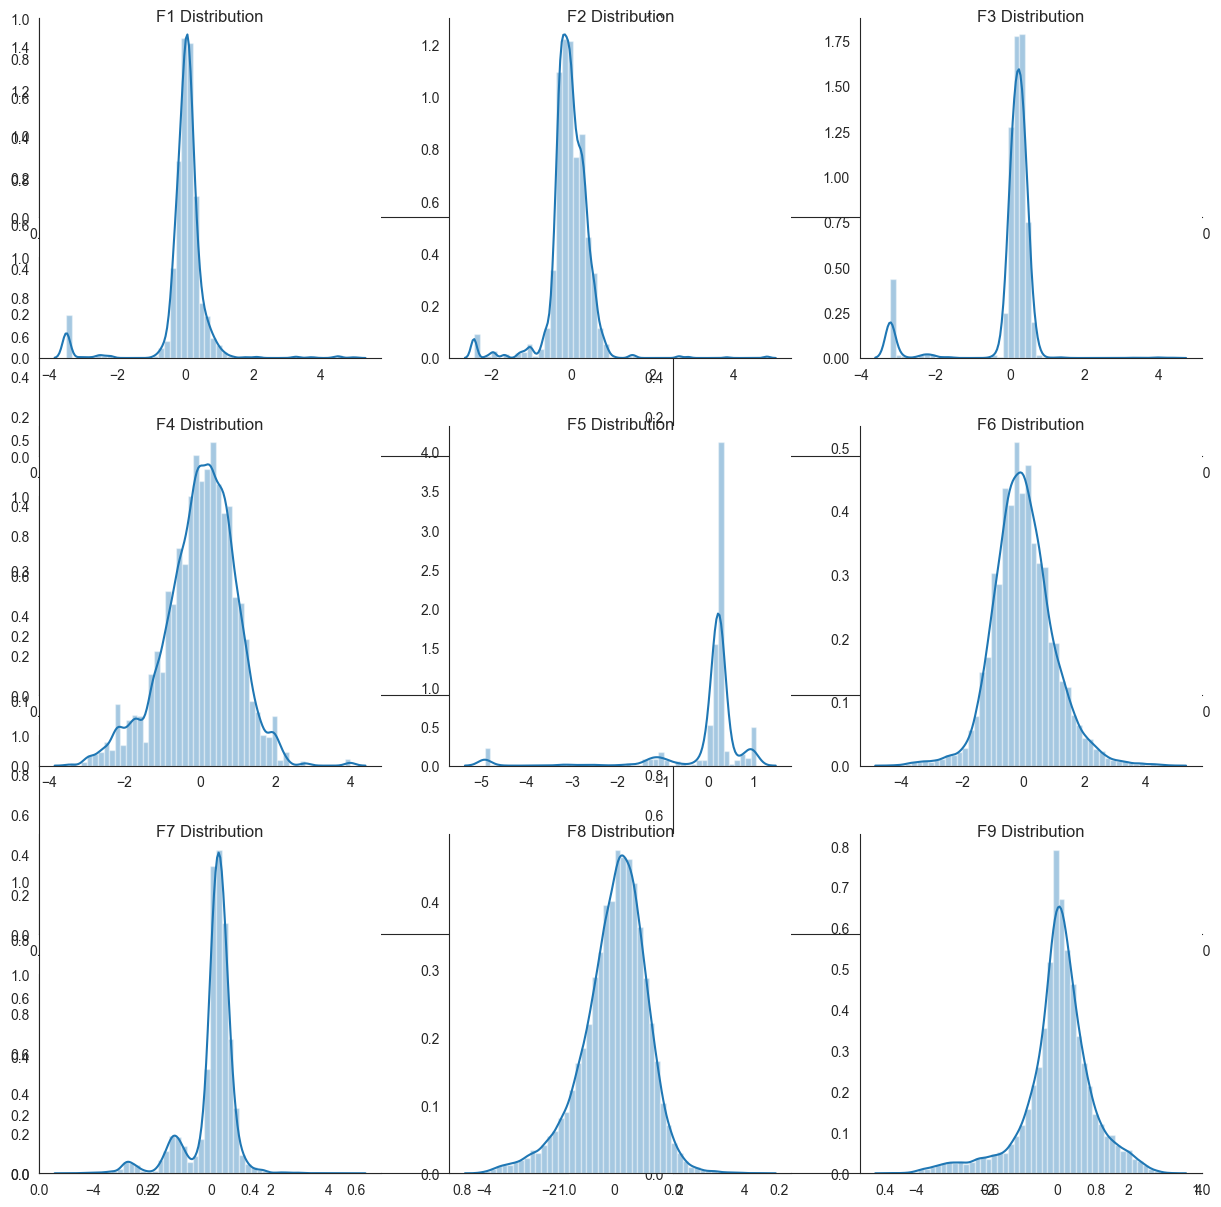

In [20]:
plt.subplots(5, 2, figsize=(15,15))

plotnumber = 1

for col in NEW_COLUMNS:
    if plotnumber < len(NEW_COLUMNS) + 1:
        plt.subplot(3, 3, plotnumber)
        
        sns.distplot(X_train[col])
        sns.despine()
        
        plt.title('{feature} Distribution'.format(feature=col), pad=-2)
        plt.xlabel(None)
        plt.ylabel(None)
        
    plotnumber += 1
    
plt.show()

### Correlation

We can see that there are still some features that have a high correlation, however, it was decided to keep those features for the purpose of modelling.

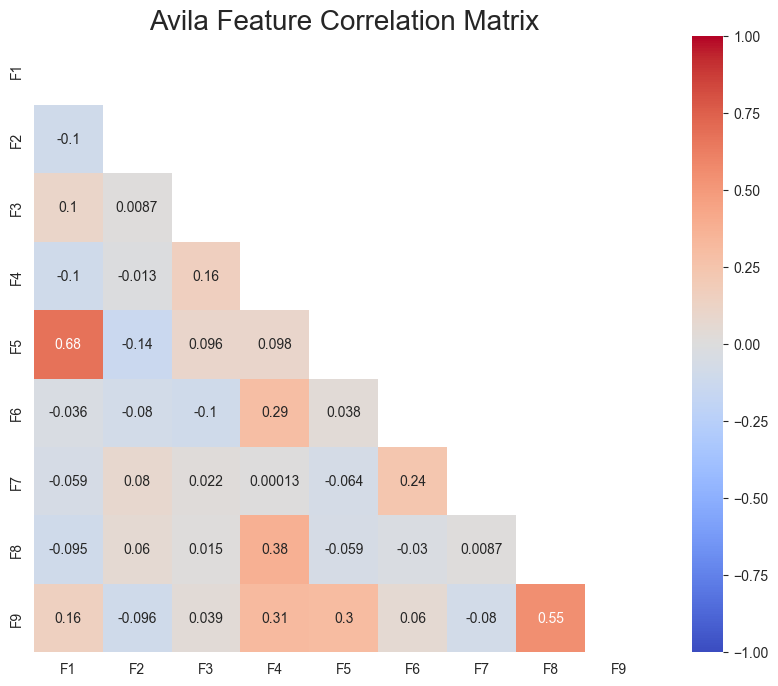

In [21]:
plt.figure(figsize = (10, 8))

corr = X_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=mask, cmap='coolwarm')

plt.title('Avila Feature Correlation Matrix', pad=5, fontdict={'fontsize':20} )

plt.show()

## Modelling

### DBSCAN Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm used in machine learning. It's designed to find clusters of data points in a dataset based on the density of data points in the feature space. DBSCAN is particularly useful when dealing with datasets where the clusters have irregular shapes or when there is noise in the data

In [22]:
X_train_dbscan = X_train.copy()

# Using the min points equal to two times the dimensions in the dataset
dbscan = DBSCAN(eps=0.5, min_samples=18).fit(X_train_dbscan)

In [23]:
X_train_dbscan['cluster'] = dbscan.labels_
X_train_dbscan['target'] = y_train
X_train_dbscan['count'] = 'count'

X_train_dbscan.head()

F1        F2        F3        F4        F5        F6        F7  \
2963   0.117948 -0.291239  0.306755  0.255993  0.172340 -0.100360  0.220177   
20300 -0.215336 -1.296191  0.491688  1.050073  0.619230  0.273364 -1.252090   
17653  0.624046  0.007106  0.114709 -0.350674  0.887365 -1.429155 -1.440842   
20121  0.229043  0.807926 -0.052442  0.082634  0.261718  0.190314  0.182426   
1457   0.315450 -0.330495  0.555703 -0.374098  0.708609 -0.557133 -0.346080   

             F8        F9  cluster target  count  
2963   0.316606 -0.216549        0      A  count  
20300  0.419022  2.122061       -1      X  count  
17653 -0.779141  1.186617       -1      I  count  
20121 -0.656008 -0.715453       -1      F  count  
1457  -0.032968  1.248980       -1      Y  count

In [24]:
classification_result = X_train_dbscan[['cluster', 'target', 'count']].groupby(['cluster', 'target']).agg('count')
classification_result.reset_index(inplace=True)
classification_result

cluster target  count
0        -1      A   3845
1        -1      B      8
2        -1      C    120
3        -1      D    385
4        -1      E   1280
5        -1      F   1271
6        -1      G    312
7        -1      H    387
8        -1      I   1293
9        -1      W     71
10       -1      X    835
11       -1      Y    416
12        0      A   2965
13        0      C     43
14        0      D    150
15        0      E    488
16        0      F   1840
17        0      G    397
18        0      H    454
19        0      X      1
20        0      Y      1
21        1      A     15
22        1      D     12
23        1      F      1
24        2      A      8
25        2      D     16
26        2      F      3
27        3      I     26
28        4      I     28
29        5      I     20

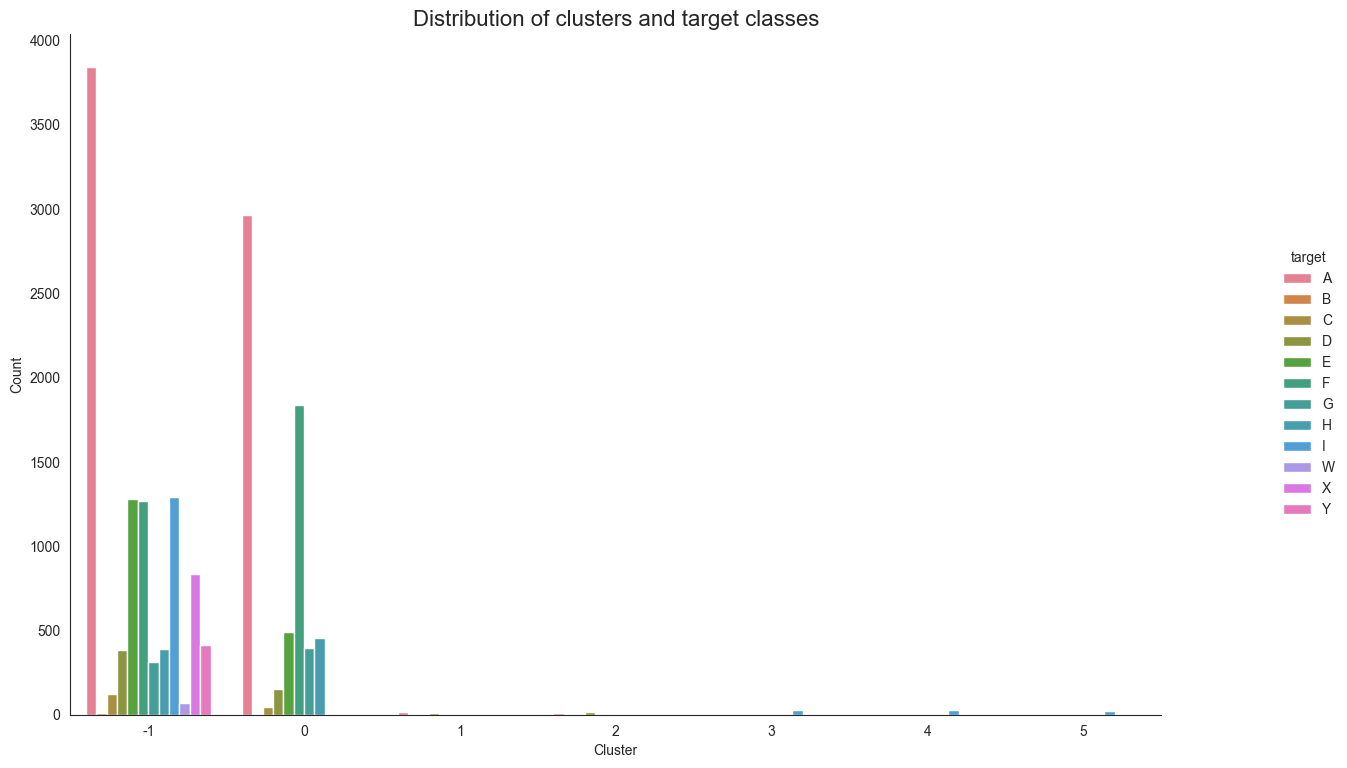

In [25]:
ax = sns.catplot(data=classification_result, x='cluster', y='count', hue='target', kind='bar', legend=True)
ax.fig.set_figwidth(15)
ax.fig.set_figheight(8)
ax.set_axis_labels('Cluster', 'Count')

plt.title('Distribution of clusters and target classes', fontdict={'fontsize':16})

plt.show()

In [26]:
ct = pd.crosstab(X_train_dbscan['target'], X_train_dbscan['cluster'])
print(ct)

cluster    -1     0   1   2   3   4   5
target                                 
A        3845  2965  15   8   0   0   0
B           8     0   0   0   0   0   0
C         120    43   0   0   0   0   0
D         385   150  12  16   0   0   0
E        1280   488   0   0   0   0   0
F        1271  1840   1   3   0   0   0
G         312   397   0   0   0   0   0
H         387   454   0   0   0   0   0
I        1293     0   0   0  26  28  20
W          71     0   0   0   0   0   0
X         835     1   0   0   0   0   0
Y         416     1   0   0   0   0   0


### PCA: Dimensionality Reduction

In order to visualise the data more effectively, we can employ Principal Component Analysis to reduce the data into principal components that best describe the variation within the data. This may assist us in visualising the clusters formed through the DBSCAN model.

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

principal_components = pca.fit_transform(X_train)

pca_df = pd.DataFrame(data = principal_components
             , columns = ['pc1', 'pc2', 'pc3'])

Here we are plotting the resulting labels of the first iteration of the DBSCAN model, to understand how the data might be clustered.

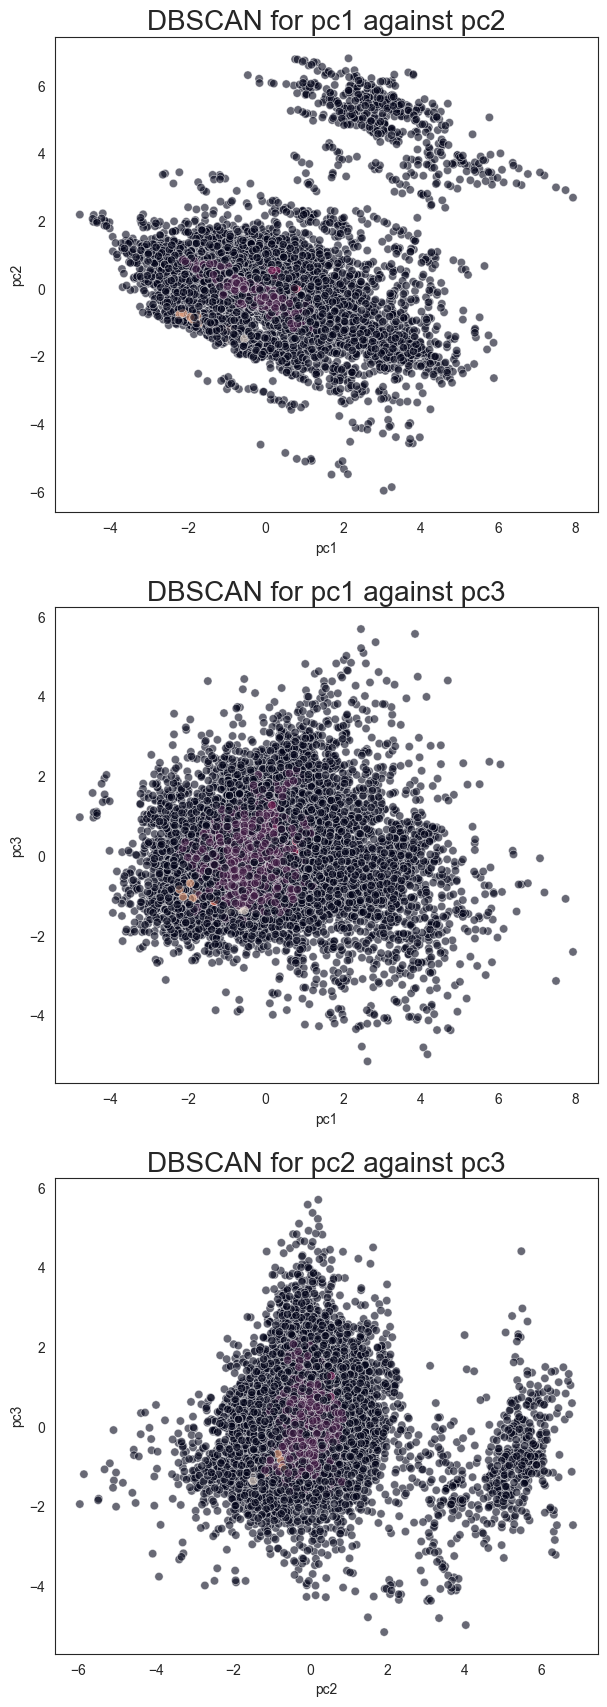

In [28]:
plt.subplots(3, 1, figsize=(7,21))

plotnumber = 1

for i in range(3):
    for j in range(2):
        if (i != j and i > j):
            plt.subplot(3, 1, plotnumber)
            sns.scatterplot(x=pca_df.iloc[:,j], y=pca_df.iloc[:,i], c=dbscan.labels_, alpha=0.6)

            plt.title('DBSCAN for {} against {}'.format(pca_df.columns[j], pca_df.columns[i]), 
                      pad=5, 
                      fontdict={'fontsize':20})
            plotnumber +=1

We can see some clusters appearing in the dataset, however, there are still quite a few data points that are being plotted as noise. We need to further fine tune eps in order to best fit this model to the data.

### DBSCAN Hyperparameter tuning

We can use a K Distance Graph to discern the optimal values for epsilon. Wherever an elbow appears in the graph shows an optimal value for epsilon. This code is referenced from K Distance example in lecture notes.

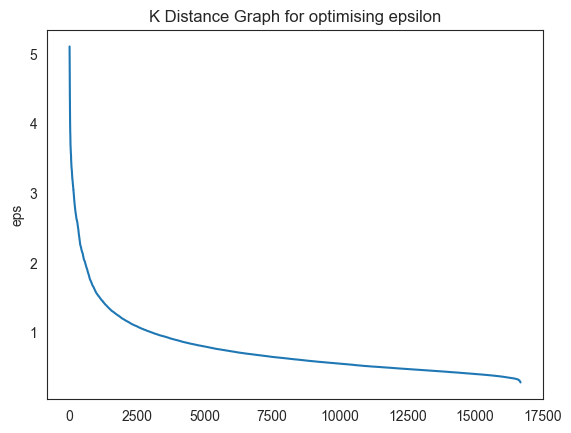

In [29]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors().fit(X_train)
distances, indices = knn.kneighbors(X_train, 20)
kDis = distances[:,10]
kDis.sort()
kDis = kDis[list(range(len(kDis) - 1, 0, -1 ))]

plt.plot(kDis)
plt.title('K Distance Graph for optimising epsilon')
plt.ylabel('eps')

plt.show()

From the graph, we can observe that the elbow occurs somewhere around eps=2, and we can interpret somewhere within this range to be the optimal value. Let us iterate over several values of epsilon to understand the value that best fits the training data and best predicts the test data. 

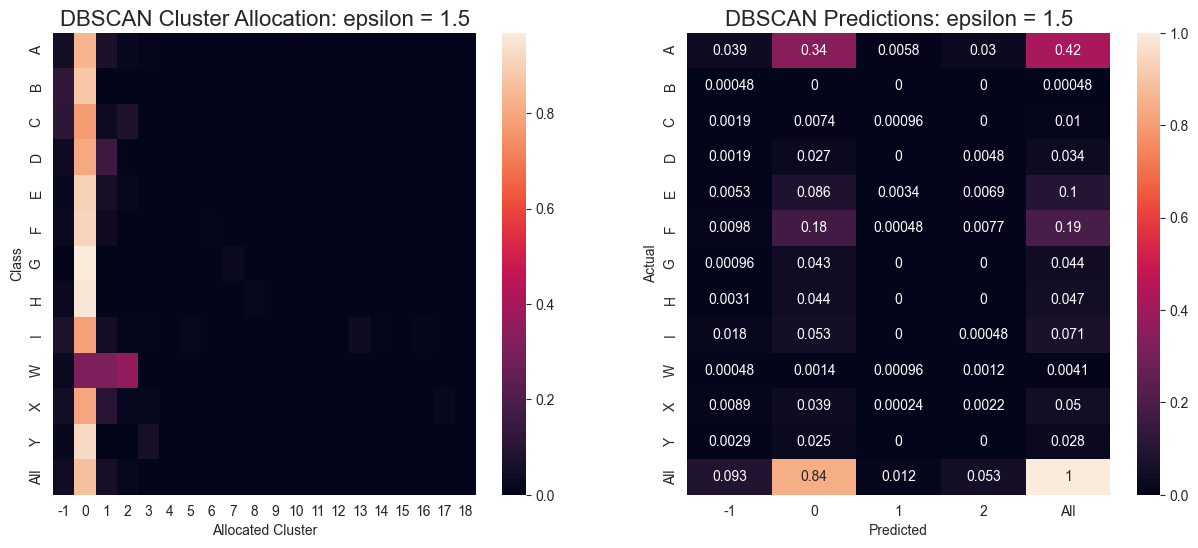

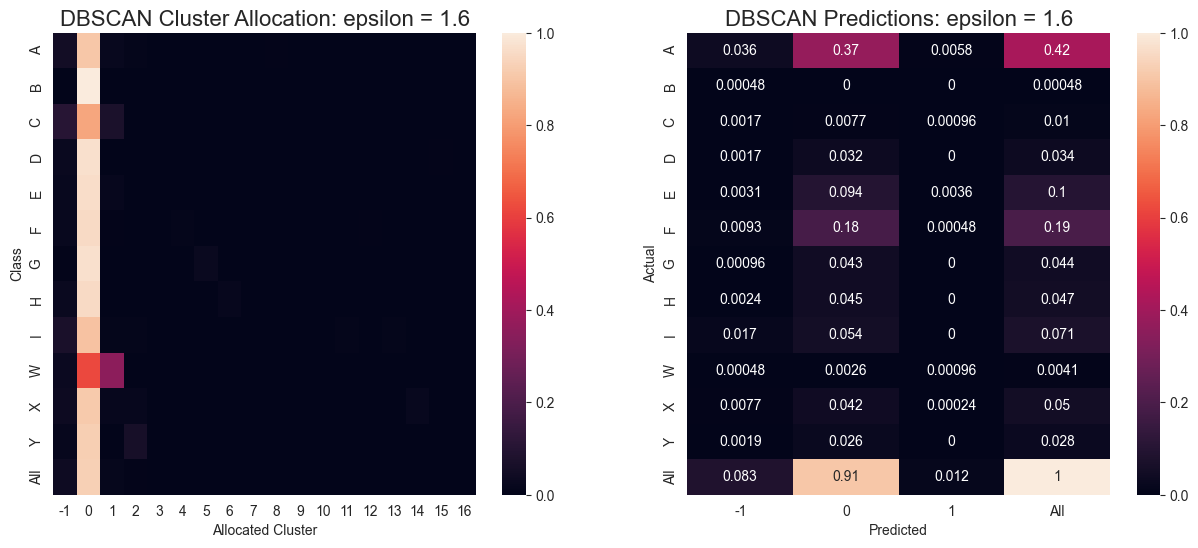

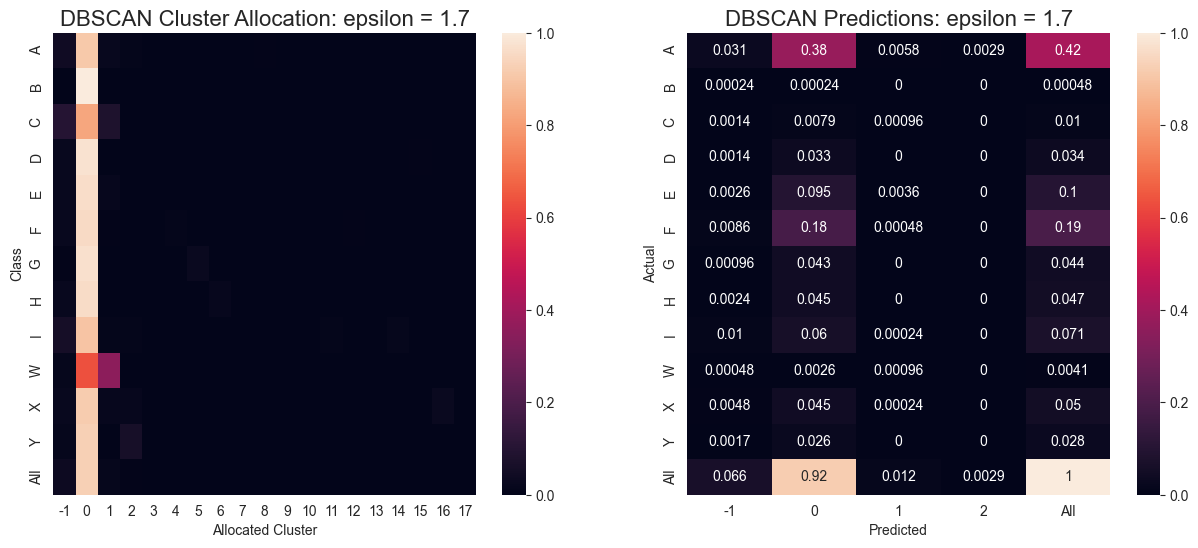

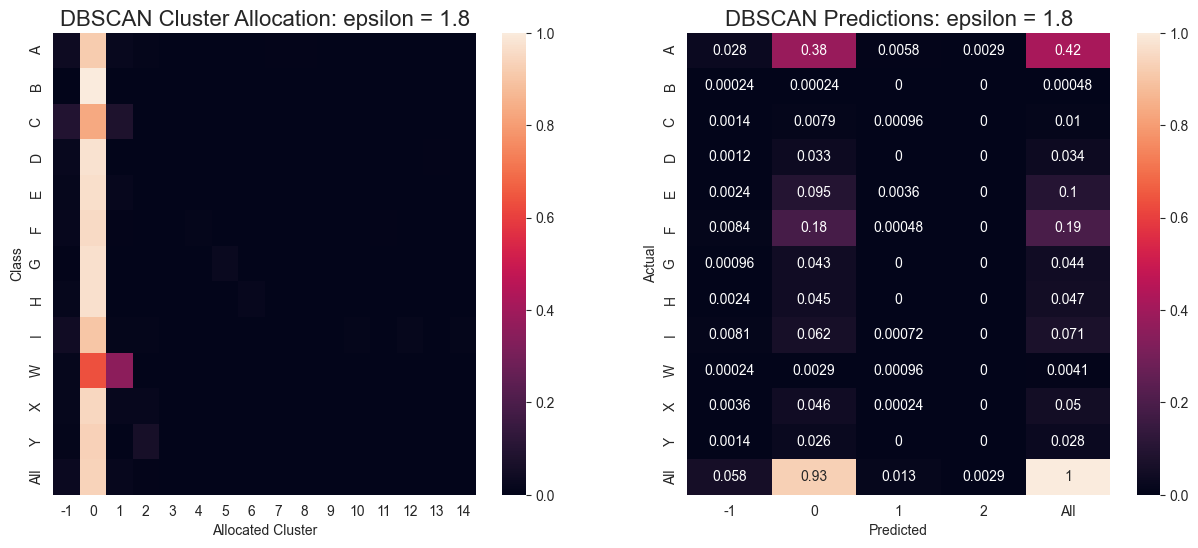

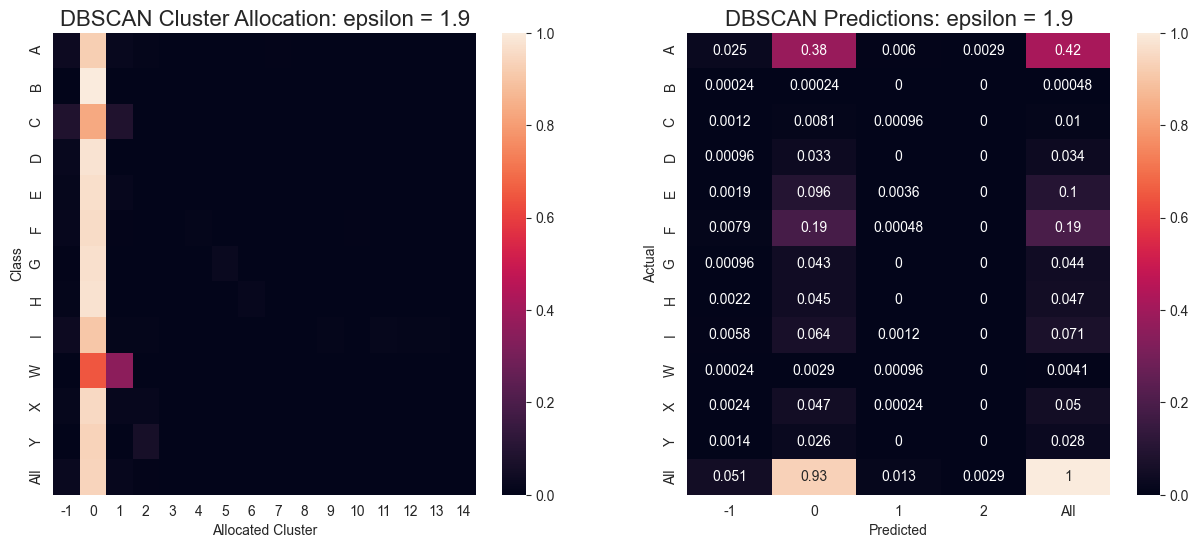

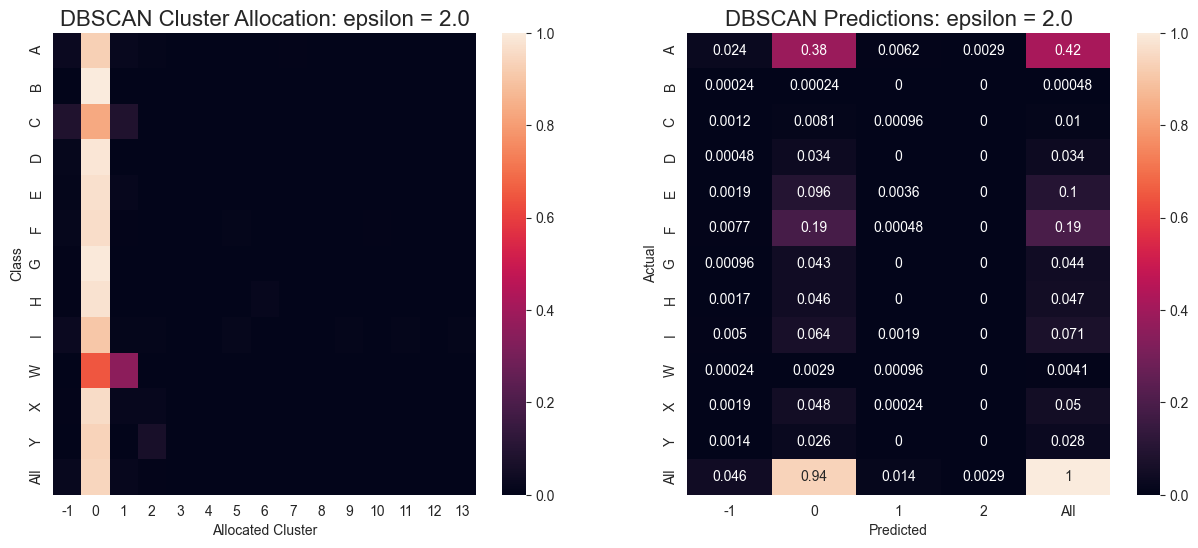

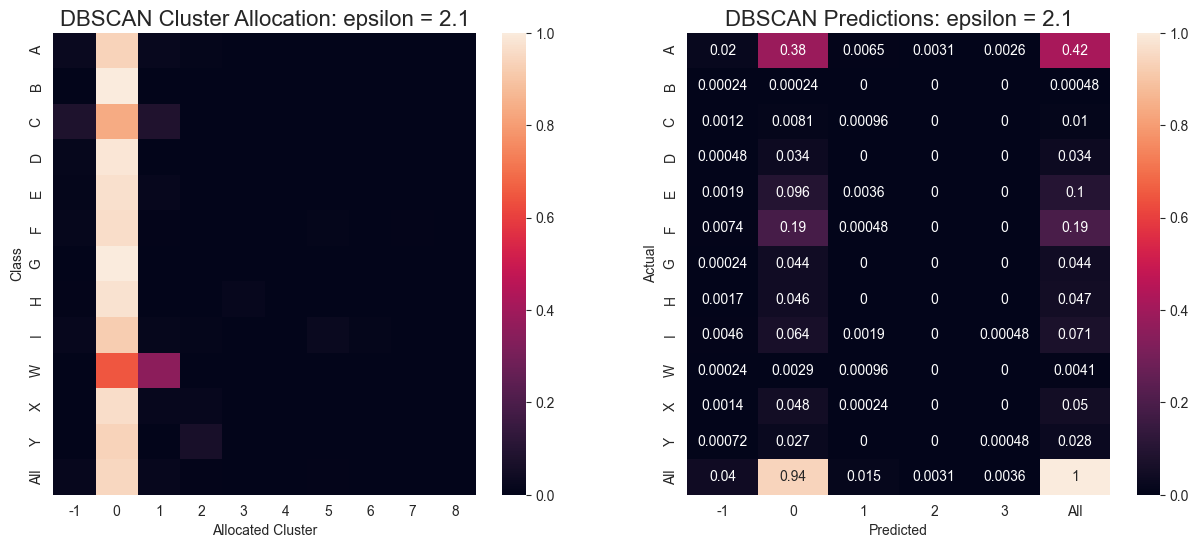

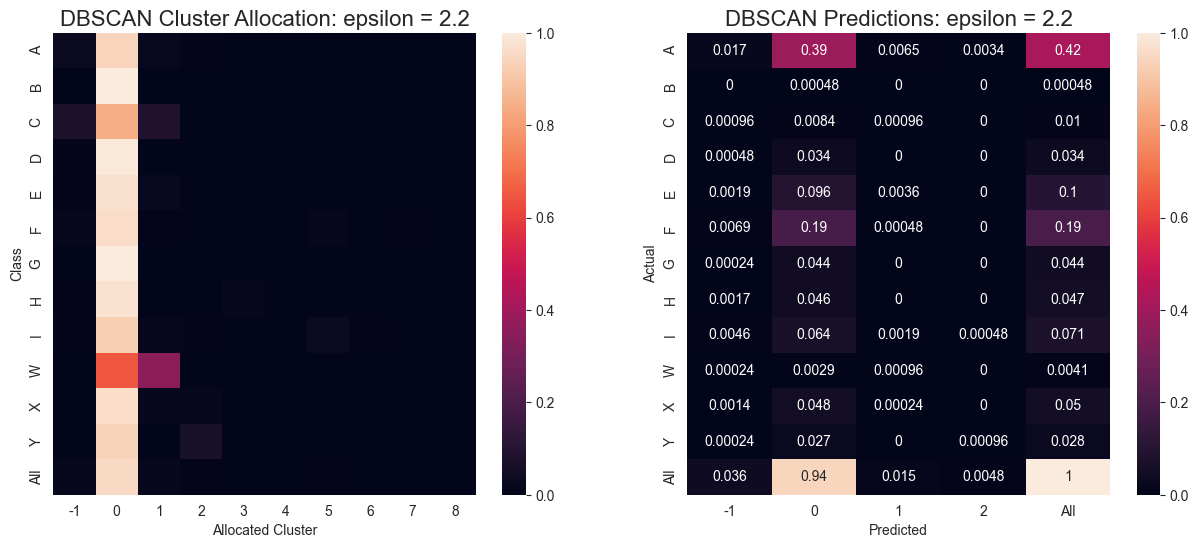

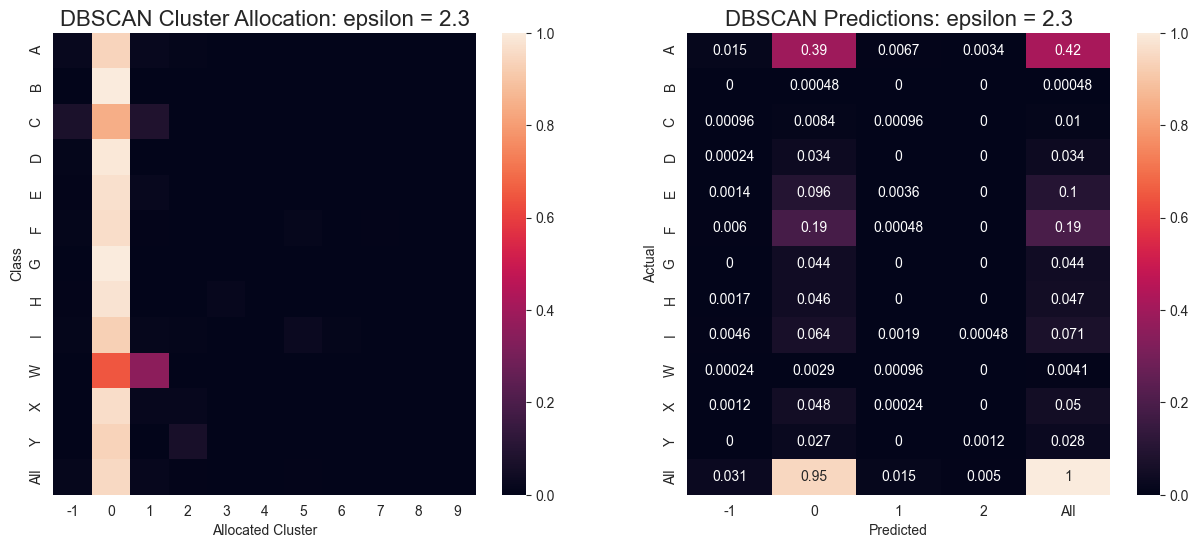

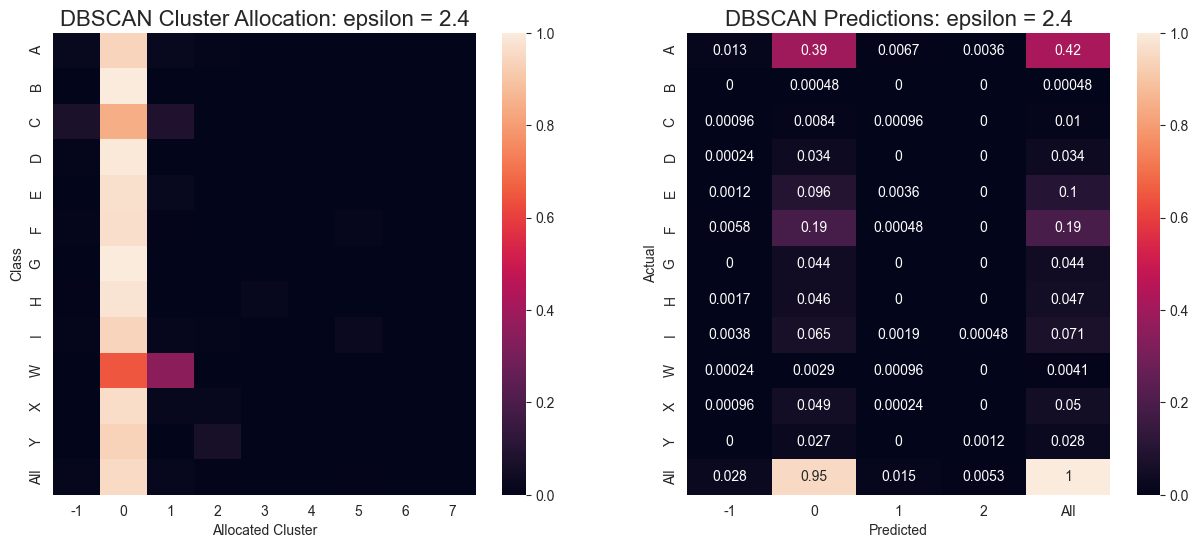

In [30]:
plotnumber = 1

for i in range (15, 25):
    
    plt.subplots(1, 2, figsize=(15,6))
    
    eps = round(0.1 * i, 1)
    
    # Fitting the algorithm to the epsilon value
    dbscan = DBSCAN(eps=eps, min_samples=12).fit(X_train)
    dbscan_labels = dbscan.labels_
    
    # Creating a confusion matrix for the fitting of the algorithm 
    ct = pd.crosstab(y_train, dbscan_labels, margins=True, normalize='index')

    # Showing the confusion matrix as a heatmap
    plt.subplot(1, 2, plotnumber)
    
    sns.heatmap(ct)
    plt.title('DBSCAN Cluster Allocation: epsilon = {}'.format(eps), pad=5, fontdict={'fontsize':16})
    plt.xlabel('Allocated Cluster')
    
    # Using the model to make predictions on the test data
    dbscan_predict = dbscan.fit_predict(X_test, y_test)
    ct_predict = pd.crosstab(y_test, dbscan_predict, margins=True, normalize='all')
    
    # Showing the results of the predictions
    plt.subplot(1, 2, plotnumber+1)

    sns.heatmap(ct_predict, annot=True)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('DBSCAN Predictions: epsilon = {}'.format(eps), pad=5, fontdict={'fontsize':16})
    
    plt.show()

It seems that when eps=1.5 the number of clusters predicted is the best, and when eps=1.9, the correct number of clusters is fit.

In [31]:
dbscan = DBSCAN(eps=1.5, min_samples=12).fit(X_train)
dbscan_labels = dbscan.labels_

In [32]:
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)

In [33]:
print('Number of clusters: {}'.format(n_clusters_dbscan))
print('Number of noisy data points: {}'.format(n_noise_dbscan))

Number of clusters: 19
Number of noisy data points: 701


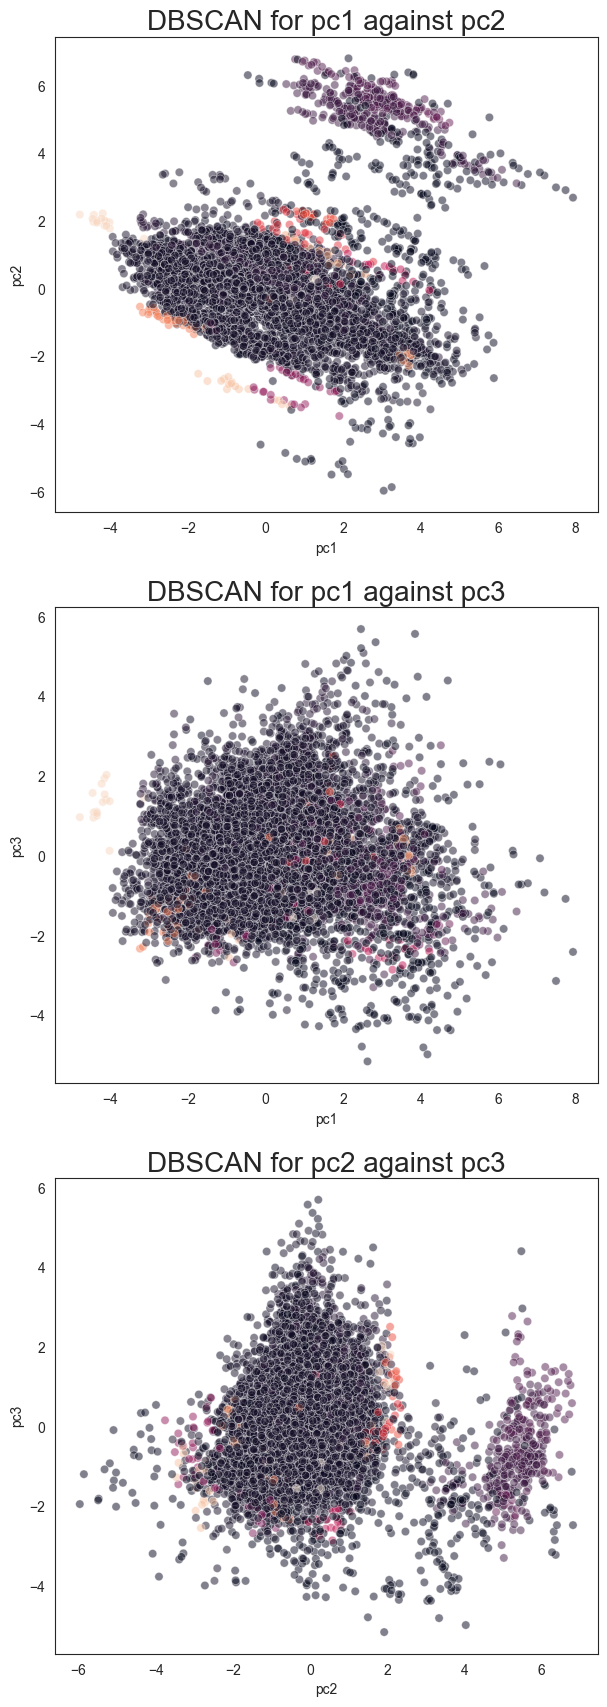

In [34]:
plt.subplots(3, 1, figsize=(7,21))

plotnumber = 1

for i in range(3):
    for j in range(2):
        if (i != j and i > j):
            plt.subplot(3, 1, plotnumber)
            sns.scatterplot(x=pca_df.iloc[:,j], y=pca_df.iloc[:,i], c=dbscan_labels, alpha=0.5)

            plt.title('DBSCAN for {} against {}'.format(pca_df.columns[j], pca_df.columns[i]), 
                      pad=5, 
                      fontdict={'fontsize':20})
            plotnumber +=1

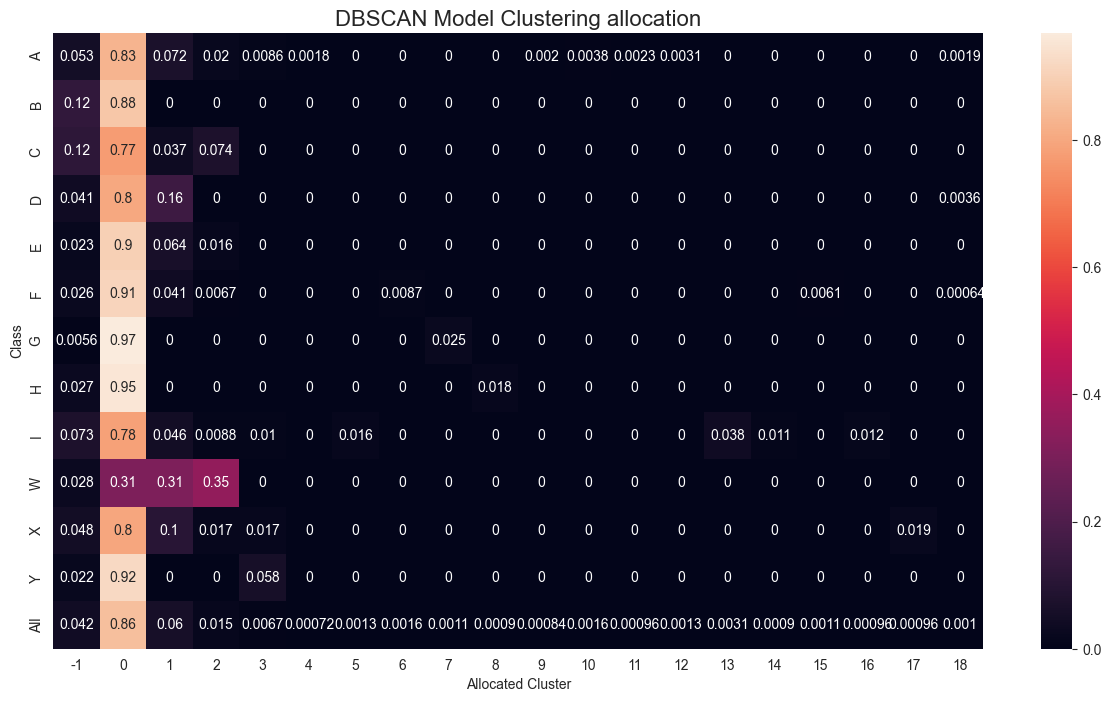

In [35]:
ct = pd.crosstab(y_train, dbscan_labels, margins=True, normalize='index')

plt.figure(figsize = (15, 8))

sns.heatmap(ct, annot=True)
plt.title('DBSCAN Model Clustering allocation', pad=5, fontdict={'fontsize':16})
plt.xlabel('Allocated Cluster')
plt.show()

In [36]:
dbscan_predict = dbscan.fit_predict(X_test, y_test)
ct_predict = pd.crosstab(y_test, dbscan_predict, margins=True, normalize='all')

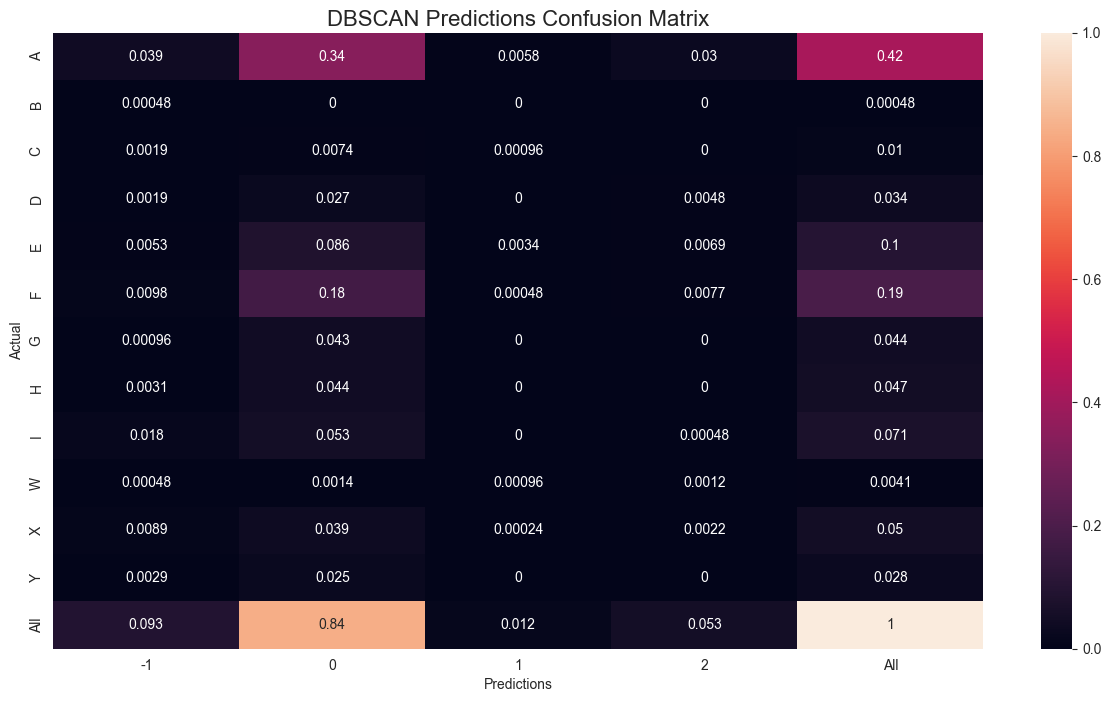

In [37]:
plt.figure(figsize = (15, 8))

sns.heatmap(ct_predict, annot=True)

plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('DBSCAN Predictions Confusion Matrix', pad=5, fontdict={'fontsize':16})
plt.show()

## K-Means

K-Means clustering is a popular unsupervised machine learning algorithm used for partitioning a dataset into a set of distinct, non-overlapping groups or clusters. These clusters are formed based on the similarity between data points, where data points within the same cluster are more similar to each other than to data points in other clusters. K-Means is widely used for various applications, including image segmentation, customer segmentation, and data compression.

In [38]:
from sklearn.cluster import KMeans
    
kmeans = KMeans(n_clusters=12, random_state=29)
results = kmeans.fit(X_train)
labels = results.labels_

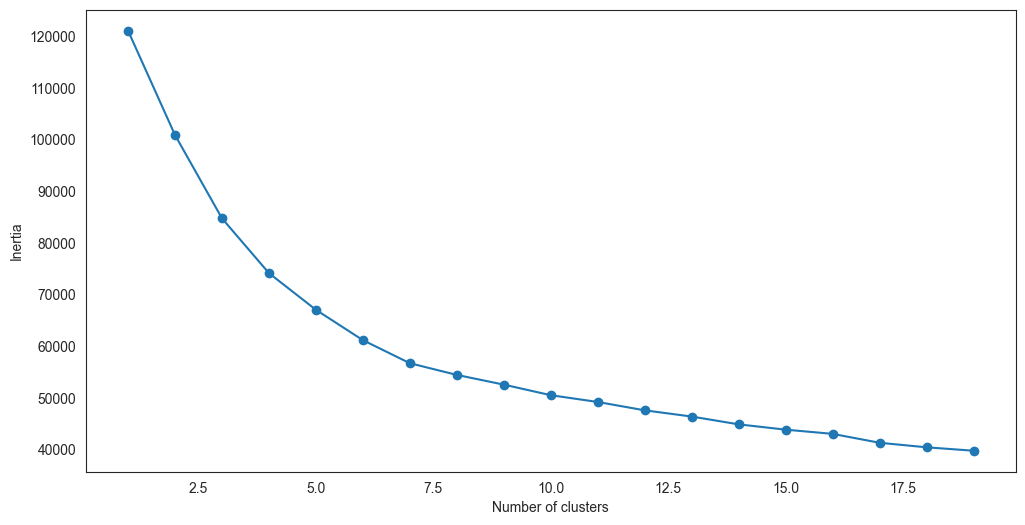

In [39]:
SSE = []

for cluster in range(1,20):
    kmeans = KMeans(n_clusters=cluster, init='k-means++')
    kmeans.fit(X_train)
    SSE.append(kmeans.inertia_)

frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.show()

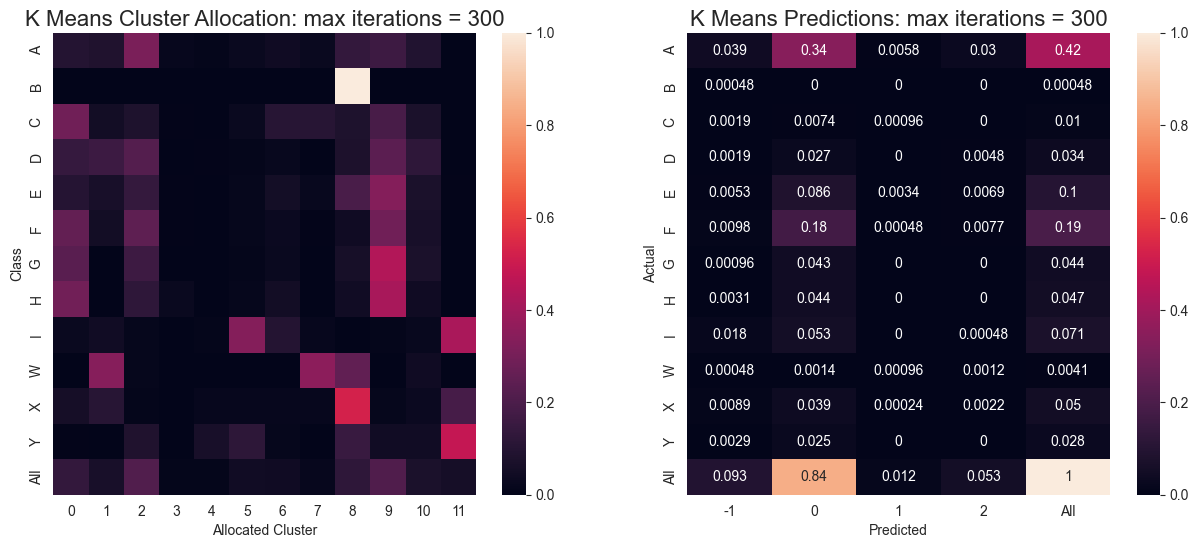

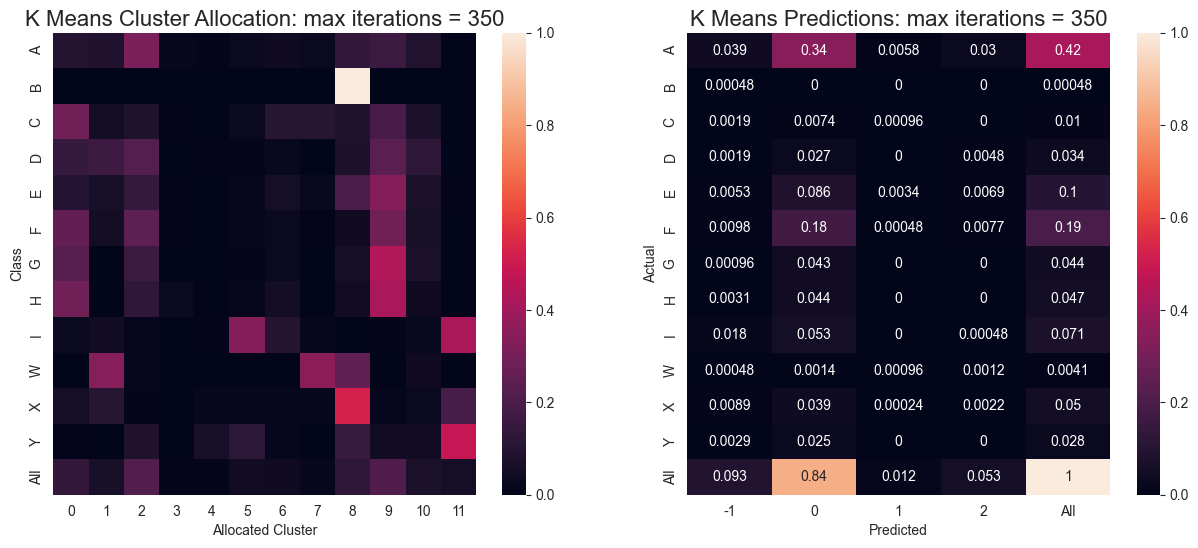

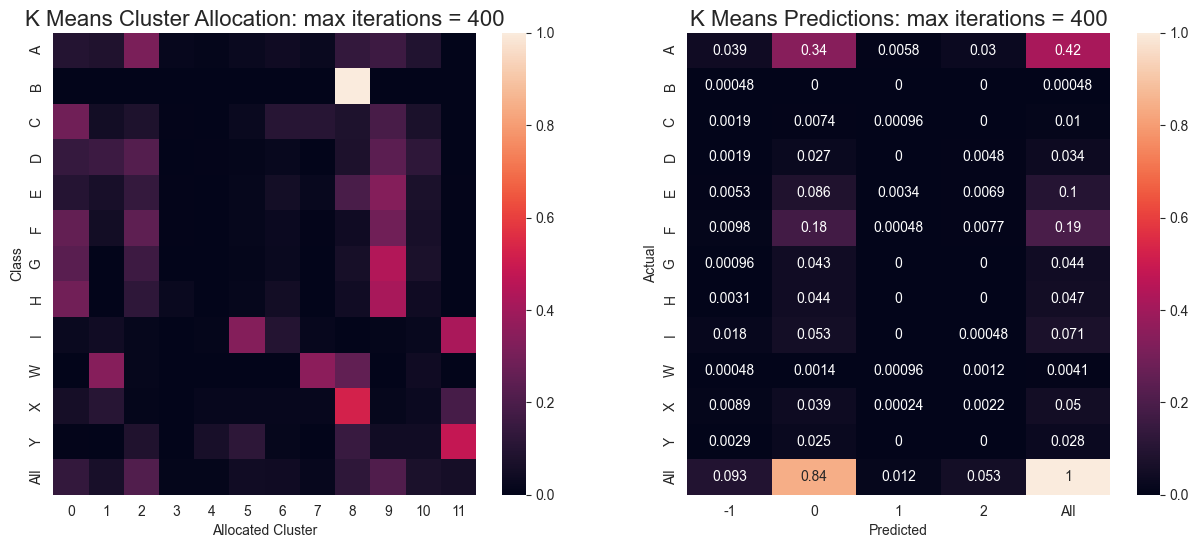

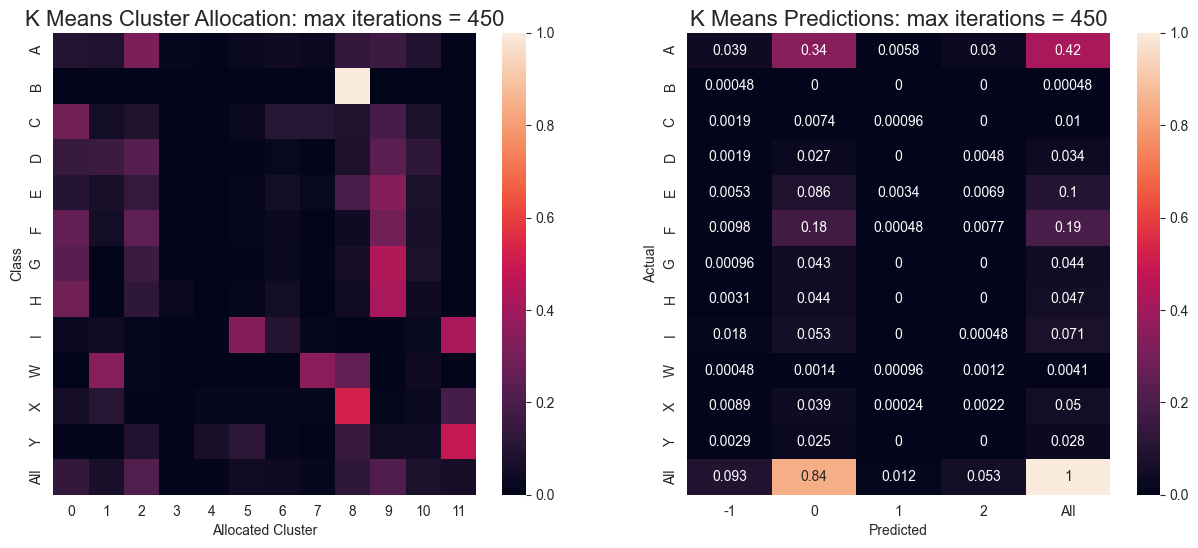

In [40]:
plotnumber = 1

for i in range(250, 450, 50):
    
    plt.subplots(1, 2, figsize=(15,6))
    
    max_iter = i + 50
    
    # Fitting the algorithm to the epsilon value
    kmeansTwo = KMeans(n_clusters=12, random_state=0, max_iter=max_iter)
    resultsTwo = kmeansTwo.fit(X_train)
    labelsTwo = resultsTwo.labels_
    
    # Creating a confusion matrix for the fitting of the algorithm 
    ct = pd.crosstab(y_train, labelsTwo, margins=True, normalize='index')

    # Showing the confusion matrix as a heatmap
    plt.subplot(1, 2, plotnumber)
    
    sns.heatmap(ct)
    plt.title('K Means Cluster Allocation: max iterations = {}'.format(max_iter), pad=5, fontdict={'fontsize':16})
    plt.xlabel('Allocated Cluster')
    
    # Using the model to make predictions on the test data
    kmeans_predict = kmeansTwo.fit_predict(X_test, y_test)
    ct_predict_kmeans = pd.crosstab(y_test, kmeans_predict, margins=True, normalize='all')
    
    # Showing the results of the predictions
    plt.subplot(1, 2, plotnumber+1)

    sns.heatmap(ct_predict, annot=True)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('K Means Predictions: max iterations = {}'.format(max_iter), pad=5, fontdict={'fontsize':16})
    
    plt.show()

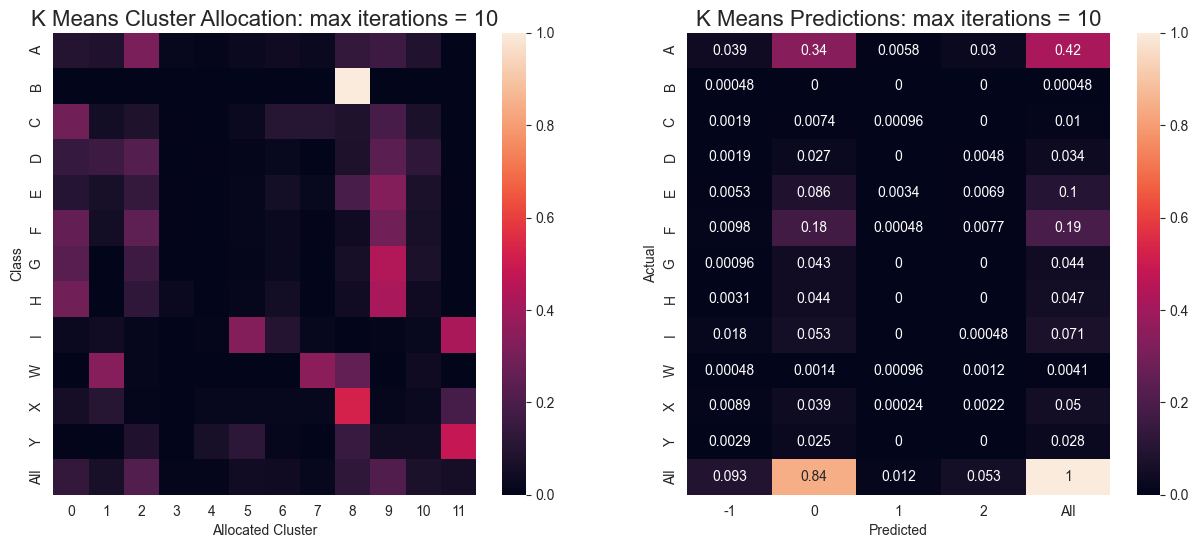

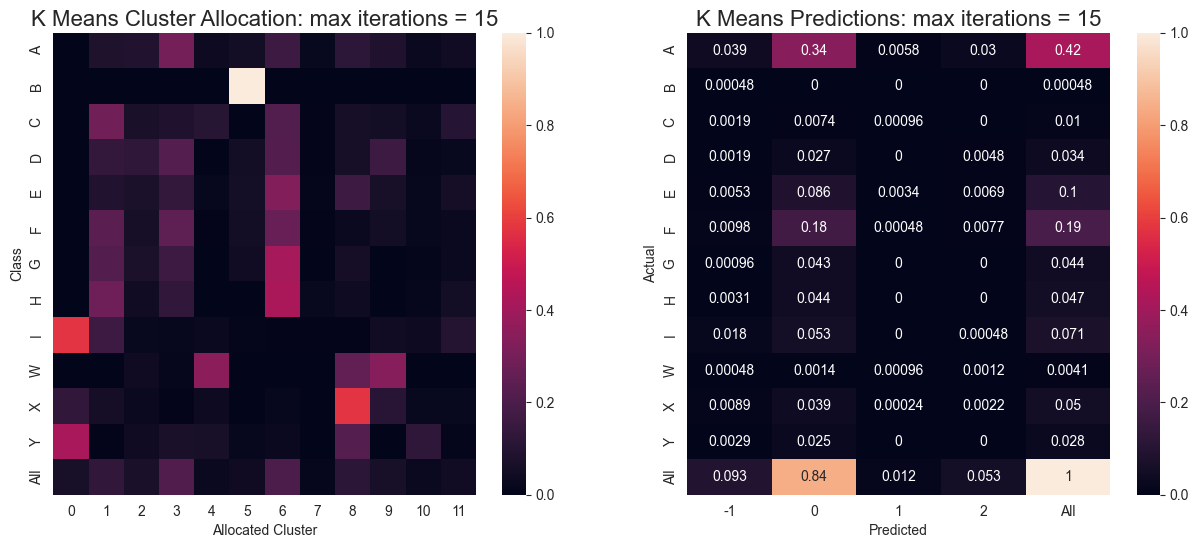

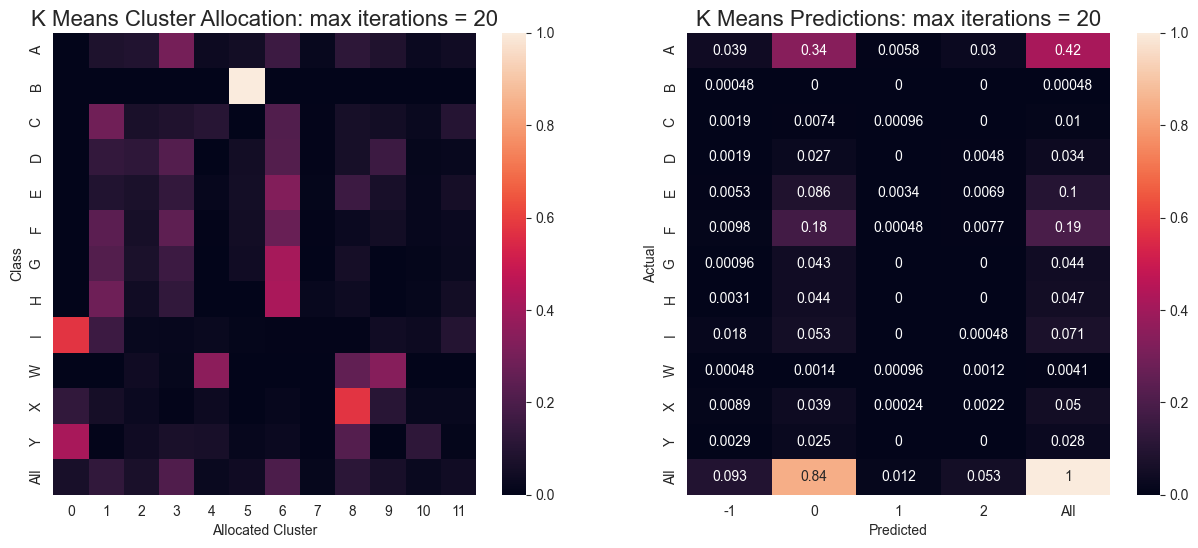

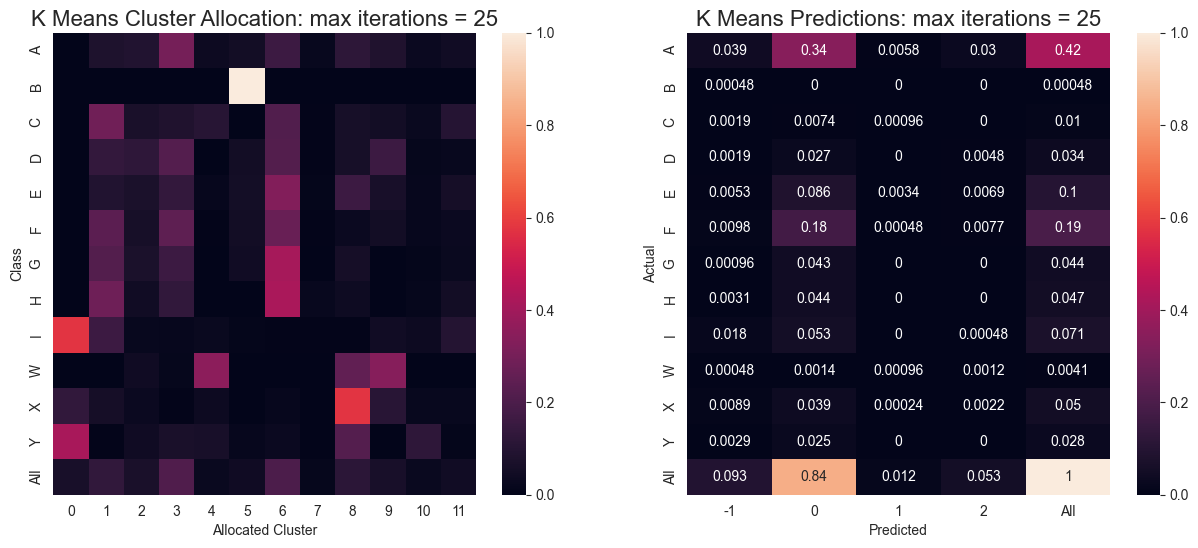

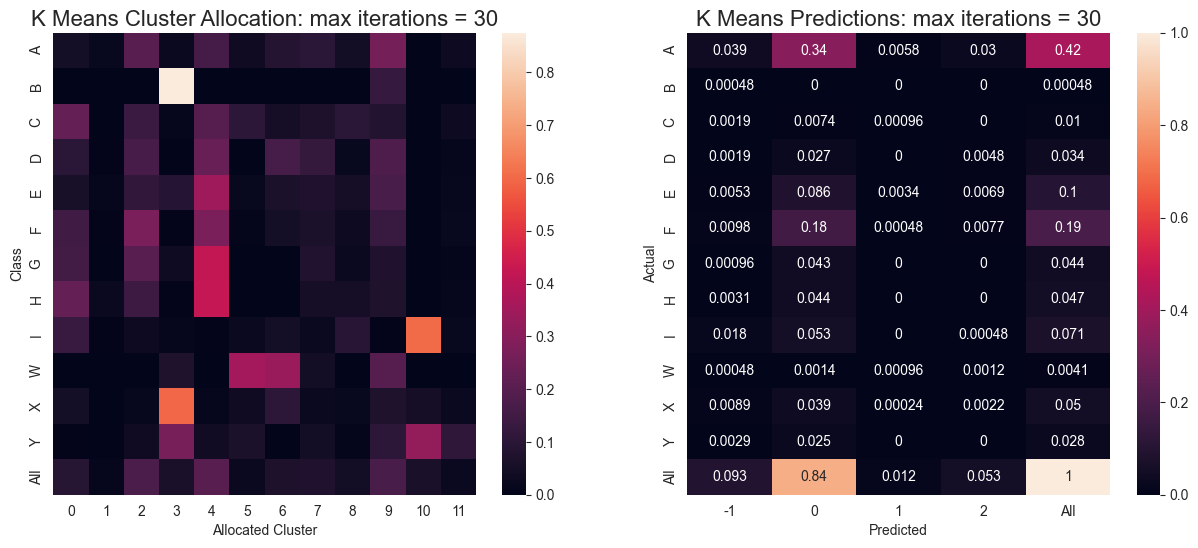

In [41]:
plotnumber = 1

for i in range(5, 30, 5):
    
    plt.subplots(1, 2, figsize=(15,6))
    
    n_init = i + 5
    
    # Fitting the algorithm to the epsilon value
    kmeansTwo = KMeans(n_clusters=12, random_state=0, n_init=n_init)
    resultsTwo = kmeansTwo.fit(X_train)
    labelsTwo = resultsTwo.labels_
    
    # Creating a confusion matrix for the fitting of the algorithm 
    ct = pd.crosstab(y_train, labelsTwo, margins=True, normalize='index')

    # Showing the confusion matrix as a heatmap
    plt.subplot(1, 2, plotnumber)
    
    sns.heatmap(ct)
    plt.title('K Means Cluster Allocation: max iterations = {}'.format(n_init), pad=5, fontdict={'fontsize':16})
    plt.xlabel('Allocated Cluster')
    
    # Using the model to make predictions on the test data
    kmeans_predict = kmeansTwo.fit_predict(X_test, y_test)
    ct_predict_kmeans = pd.crosstab(y_test, kmeans_predict, margins=True, normalize='all')
    
    # Showing the results of the predictions
    plt.subplot(1, 2, plotnumber+1)

    sns.heatmap(ct_predict, annot=True)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('K Means Predictions: max iterations = {}'.format(n_init), pad=5, fontdict={'fontsize':16})
    
    plt.show()

In [42]:
X_train_kmeans = X_train
X_train_kmeans["cluster"] = results.predict(X_train_kmeans)
X_train_kmeans["target"] = y_train
X_train_kmeans["c"] = "forCounting"

kmeans_results = X_train_kmeans[["cluster", "target", "c"]].groupby(["cluster", "target"]).agg("count")
kmeans_results.reset_index(inplace=True)
print(kmeans_results)

     cluster target     c
0          0      A   274
1          0      C    34
2          0      D    52
3          0      E    88
4          0      F   377
5          0      G   100
6          0      H   177
7          0      I   195
8          0      X    32
9          0      Y     2
10         1      A   312
11         1      B     7
12         1      C     4
13         1      D     6
14         1      E   211
15         1      F    37
16         1      G    30
17         1      H     7
18         1      I    13
19         1      W    12
20         1      X   488
21         1      Y   106
22         2      A   631
23         2      C    12
24         2      D    68
25         2      E   119
26         2      F   183
27         2      G    52
28         2      H    37
29         2      I    26
30         2      W     3
31         2      X    21
32         2      Y    16
33         3      A   285
34         3      C    16
35         3      D    11
36         3      E    89
37         3

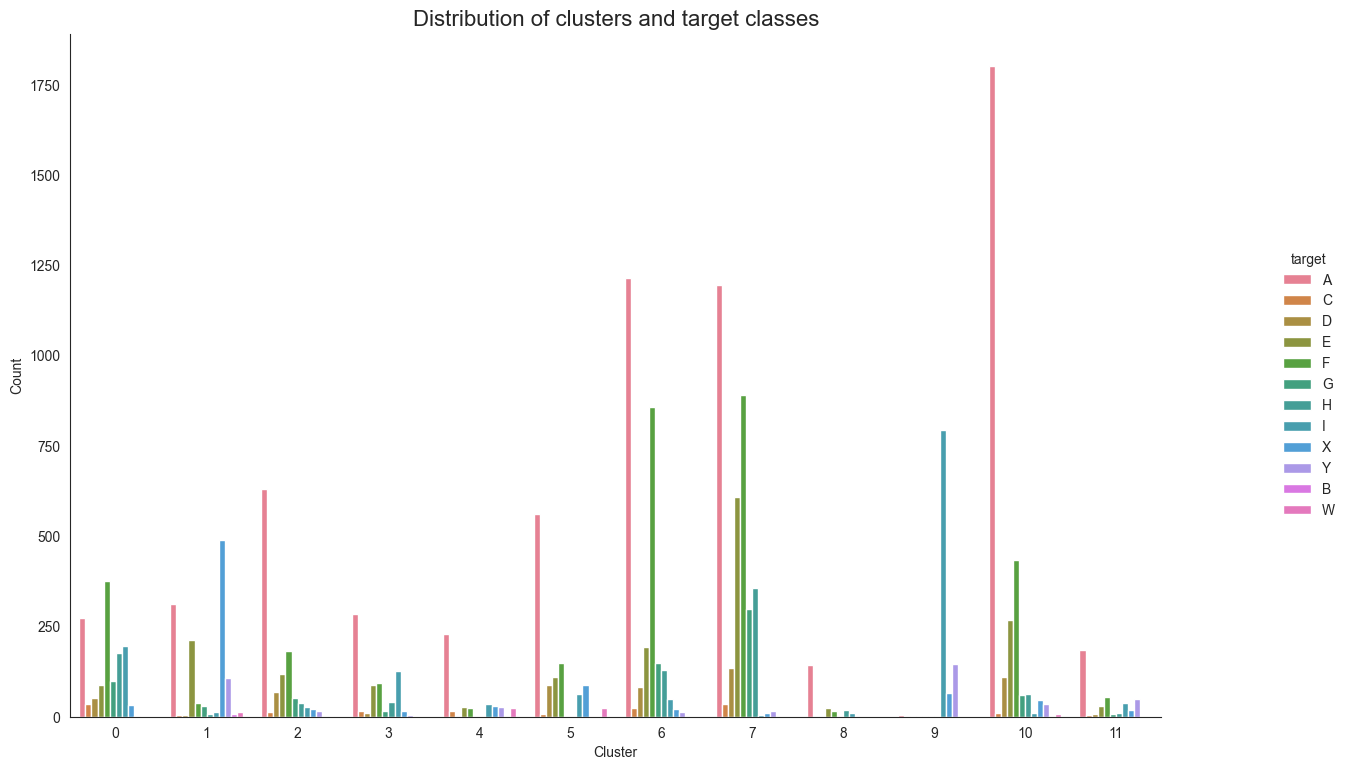

In [43]:
ax = sns.catplot(data=kmeans_results, x="cluster", y="c", hue="target", kind='bar', legend=True)
ax.fig.set_figwidth(15)
ax.fig.set_figheight(8)
ax.set_axis_labels('Cluster', 'Count')

plt.title('Distribution of clusters and target classes', fontdict={'fontsize':16})
plt.show()

### K Means: Visualisation Cluster Membership

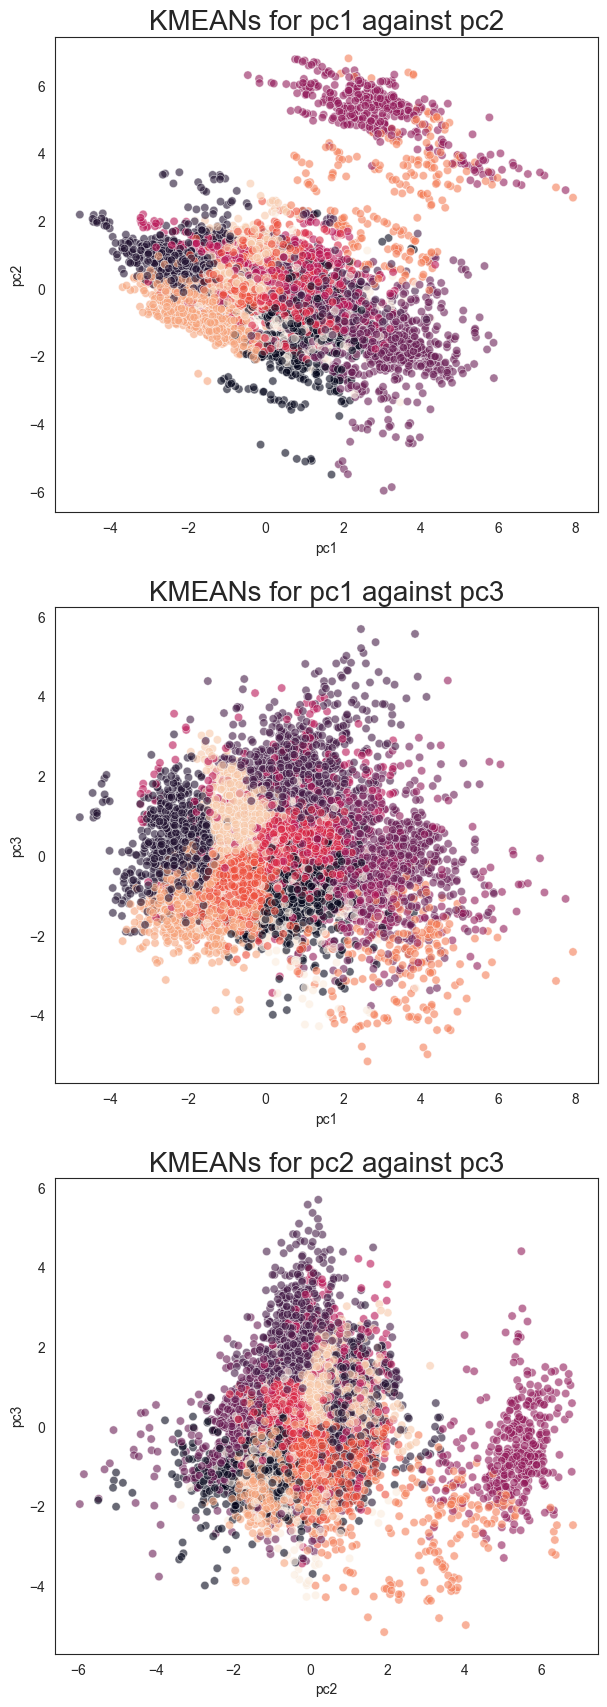

In [44]:
plt.subplots(3, 1, figsize=(7,21))

plotnumber = 1

for i in range(3):
    for j in range(2):
        if (i != j and i > j):
            plt.subplot(3, 1, plotnumber)
            sns.scatterplot(x=pca_df.iloc[:,j], y=pca_df.iloc[:,i], c=labels, alpha=0.6 )

            plt.title('KMEANs for {} against {}'.format(pca_df.columns[j], pca_df.columns[i]), 
                      pad=5, 
                      fontdict={'fontsize':20})
            plotnumber +=1

In [45]:
kmeans_predict = kmeans.fit_predict(X_test, y_test)
ct_predict_kmeans = pd.crosstab(y_test, kmeans_predict, margins=True, normalize='all')

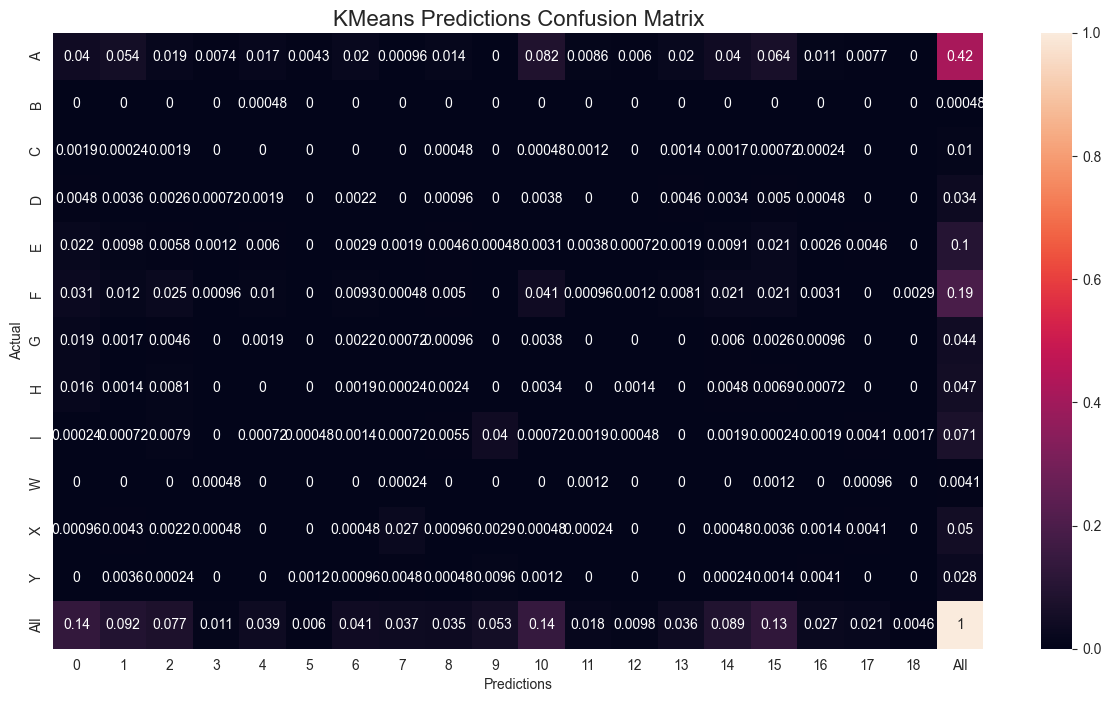

In [46]:
plt.figure(figsize = (15, 8))

sns.heatmap(ct_predict_kmeans, annot=True)

plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('KMeans Predictions Confusion Matrix', pad=5, fontdict={'fontsize':16})\

plt.show()